In [180]:
import numpy as np
import regex as re
import pandas as pd
import pickle
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.lines import Line2D


#from netwulf import visualize
#import netwulf as nw
#from numba import jit

#import pydot
from graph_rune import create_bipartite_graph, set_politician_attributes, create_color_map
import networkx as nx
#import community for community detection
import community as community_louvain

import datetime


### Goal: investigate which politicians are present the entire time for each period and establish some threshold to remove nodes that are not sufficiently present

In [181]:
#load data from df_law_clean.pickle
with open('df_law_clean.pickle', 'rb') as f:
    df = pickle.load(f)


### The problem of politicians that have only been part of a portion of a given period - scewed data
Since we are creating a unipartite graph and relying on the weights between politicians in a given period to determine how much they collaborate, based solely on the shared amount of 'yes votes', it is a problem if we have some politicians in our dataset with very few votes in a given period. Hence, not having voting, counts equally much against being in a community with a yes voter, as simply not being present. One way to fix this, would be to set some empirical values as to influence the weight so that a yes-no vote between two politicians for the same law provides a more negative score, than a yes-absent. 

Even with weighting the vote types, we are however still faced with the problem of politicians that have less than 100% votes when including both yes, no, absent and blank votes. This could happen if there was some mistake in the registration of votes, but will certaintly happen when a politician due to serius sickness, maternity leave, quitting etc. is no longer part of the parlaimentary work, or when a substitution enters in midst of a period. If we include politicians that for whatever reason may just have participated in some % of the votings that year, we expect that this wil scew our community detection significantly as the weights will make it appear as if this person disagree with the majority of the other politicians that they in fact agreed with (given that much fewer edges will be created for a politician that did fewer votings). 

A solution would be to scale the weight of the edges in a network, based on the % of total votings they have been part of in that given period (including both absent, blank, yes and no votes), or simply remove politicians that have only been partially involved in the votings for a given year (perhaps at some reasonable threshold).

### Removing politicians that have not participated in the majorty of votings
We decided to proceed with the approach of removing politicians

After having check a few periods, it seems to make sense to make a threshold at 90% of max votes

In [182]:
#This function takes a periode_id and calculates the 90% threshold for that period
def threshold_periode(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return 0.9 * max(dict_politicians.values())


In [183]:
#This function takes a periode_id and returns a list of politicians who have voted more than 90% of the time
def active_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    threshold = 0.9 * max(dict_politicians.values())

    return [key for key, value in dict_politicians.items() if value > threshold]

In [184]:
#This function does the same as above, but without the threshold
def all_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return [key for key, value in dict_politicians.items()]

In [185]:
#We find all unique periode_ids
periode_ids = df['periode_id'].unique()

#We make a dict of active politicians for each periode_id
dict_active_politicians = defaultdict()
for periode_id in periode_ids:
    dict_active_politicians[periode_id] = active_politicians(periode_id)


In [186]:
df['votes_adjusted'].isna().sum()

0

In [187]:
#We make a new pandas dataframe, where we go through votes_adjusted and only keep the votes from active politicians
df_active = pd.DataFrame(columns=['periode_id', 'votes_adjusted'])
for index, row in df.iterrows():
    votes_adjusted = row['votes_adjusted']
    votes_adjusted = [vote for vote in votes_adjusted if vote['aktørid'] in dict_active_politicians[row['periode_id']]]
    df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel

In [188]:
#Initialize defaultdict for politicians
politicians_lost = defaultdict()
politicians_active = defaultdict()

for period in periode_ids:
    #Number of politicans who voted in each vote
    all_pol = all_politicians(period)
    active_pol = active_politicians(period)
    politicians_lost[period] = len(all_pol) - len(active_pol)
    politicians_active[period] = len(active_pol)


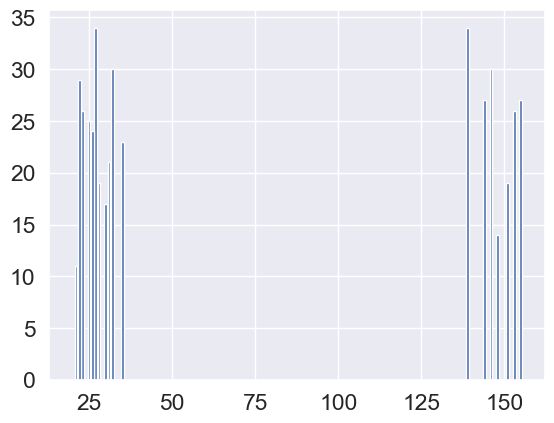

The average number of politicians dropped per period is 19.818181818181817


In [189]:
#Make a histogram of the number of politicians lost per period with periode_id as x-axis
plt.bar(politicians_lost.keys(), politicians_lost.values())
plt.show()
print('The average number of politicians dropped per period is', np.mean(list(politicians_lost.values())))

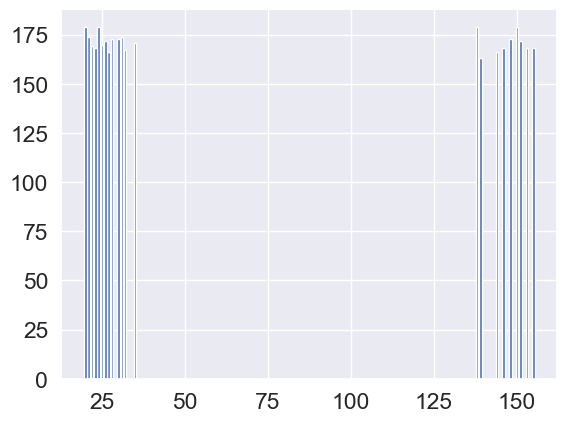

The average number of politicians that we consider per period is 171.4090909090909


In [190]:
#Make a histogram of the number of active politicians with periode_id as x-axis
plt.bar(politicians_active.keys(), politicians_active.values())
plt.show()
print('The average number of politicians that we consider per period is', np.mean(list(politicians_active.values())))

Given that there are at any time 179 politicians in the parlaiment, we believe that by sorting off less than 8 politicians pr. period on average, our data analysis will still be representative. 

In [191]:
df_active['votes_adjusted'].isna().sum()

0

In [192]:
df_active.head()

,periode_id,votes_adjusted
0,32,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,31,"[{'id': 850408, 'typeid': 1, 'afstemningid': 4..."
2,32,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
3,32,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
4,32,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."


In [193]:
#add the df_active to the df
df['votes_adjusted_active'] = df_active['votes_adjusted']

In [194]:
#pickle the new dataframe
#with open('df_law_active.pickle', 'wb') as f:
#   pickle.dump(df, f)

#load data from df_law_active.pickle
with open('df_law_active_rune.pickle', 'rb') as f:
    df = pickle.load(f)

In [195]:
len(df)

3762

In [196]:
#remove nan
df = df[df['votes_adjusted_active'].notna()]

#count nan
df['votes_adjusted_active'].isna().sum()

0

In [197]:
len(df)

3696

In [198]:
#create a networkx graph for period 32
df32 = df[df['periode_id'] == 32]

G = create_bipartite_graph(df32)

#set attributes for politicians
G = set_politician_attributes(G)

In [199]:
#Function to check for isolate nodes
def remove_isolate_nodes(G):
    isolate_nodes = list(nx.isolates(G))
    if len(isolate_nodes) > 0:
        G.remove_nodes_from(isolate_nodes)
        print(f'Removed {len(isolate_nodes)} isolate nodes')
    else:
        print('No isolate nodes')
    return G

In [200]:
#clean graph
#remove the isolated nodes
remove_isolate_nodes(G)

law_nodes, politician_nodes = nx.bipartite.sets(G)

color_map = create_color_map() #defined in graph_functions.py

No isolate nodes


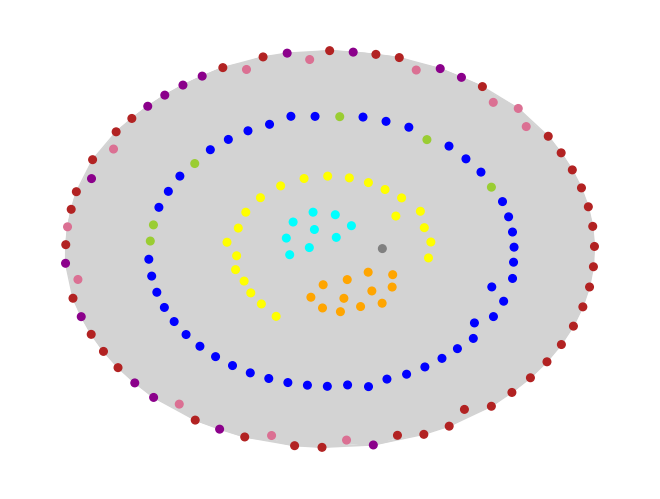

In [201]:

G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

pos = nx.kamada_kawai_layout(G_uni)
#pos = nx.fruchterman_reingold_layout(G_uni, k=0.5, iterations=50)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()])



In [202]:
#Do clustering on the graph using the Louvain algorithm
partition = community_louvain.best_partition(G_uni)

#print number of clusters
print(len(set(partition.values())))


3


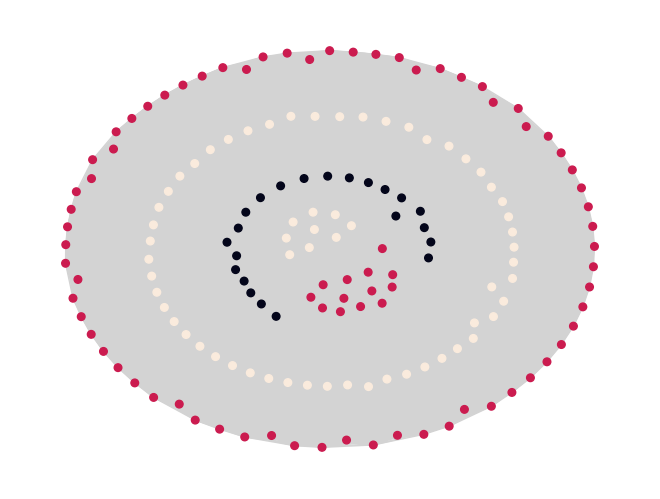

In [203]:
#plot the graph with the clusters
pos = nx.kamada_kawai_layout(G_uni)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_uni.nodes()])
plt.show()

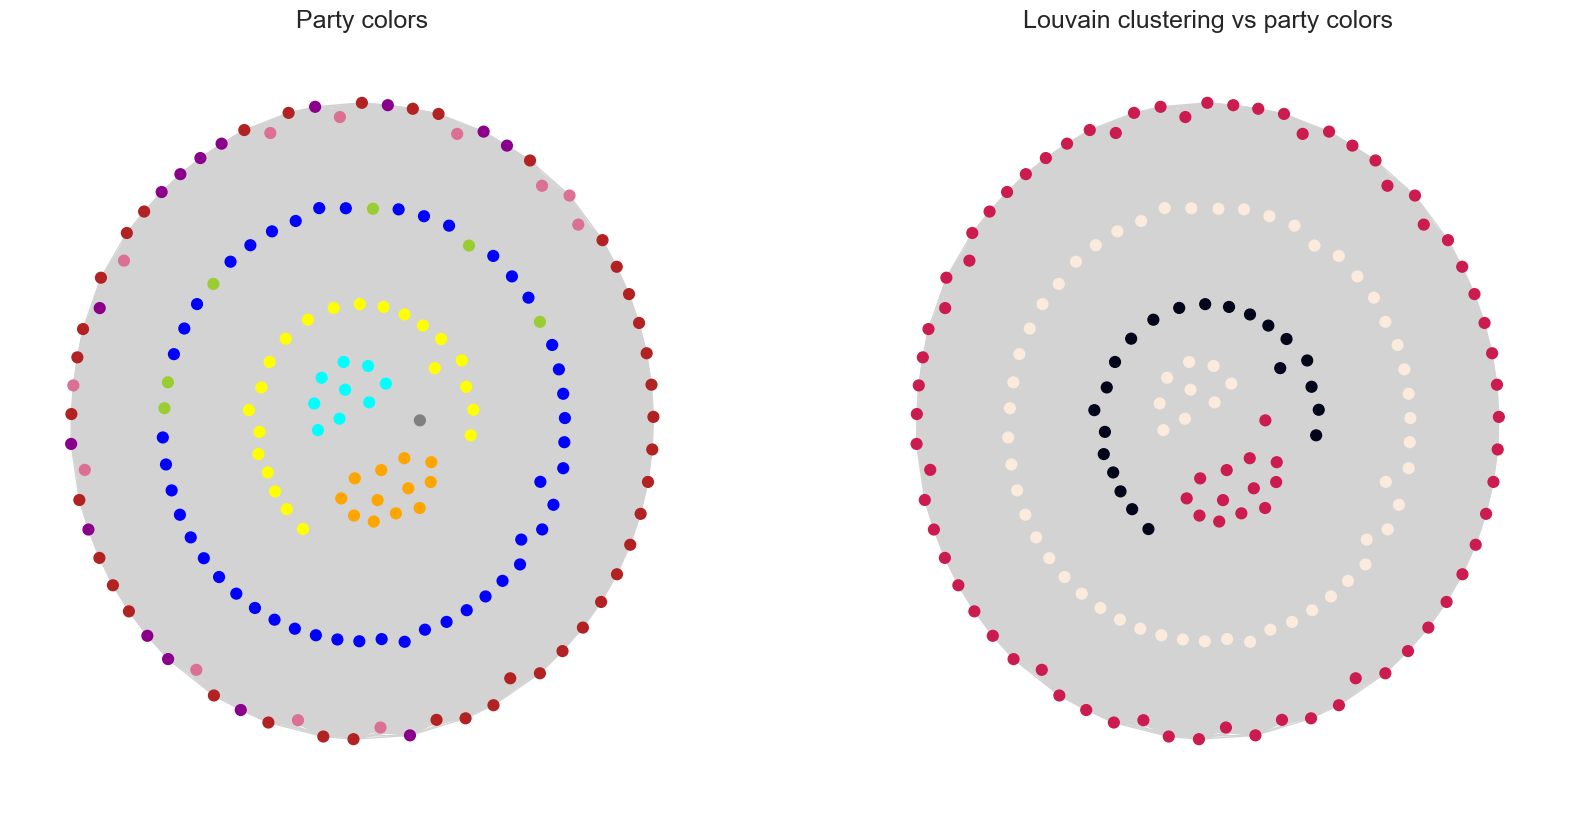

In [204]:
#plot the graph with the clusters in a subgraph
#two horizontally stacked subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#create random colors for the clusters
colors = [np.random.rand(3,) for i in range(len(set(partition.values())))]

#plot the networkx graph in ax1 
pos = nx.kamada_kawai_layout(G_uni, weight='weight', scale=100)
nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_uni.nodes()], ax=ax2)
#plot it with party colors
nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()], ax=ax1)

ax2.set_title('Louvain clustering')
ax1.set_title('Party colors')
plt.title('Louvain clustering vs party colors')
plt.show()

In [205]:
#Who is the grey (out of folketingsgruppe) politician?
for node in G_uni.nodes():
    if G_uni.nodes[node]['color'] == 'grey':
        #print name attribute of the node
        print(G_uni.nodes[node]['name'])

Uffe Elbæk


In [206]:
#Uffe Elbæk left radikale venstre in 2013, and this period covers 2014-2015 - makes sense.

### We first plot the clustering over time for each period and check if the same parties are in the same clusters and if certain individuals are not in the same cluster as their party

In [207]:
#loading politician info from pickle politician_df_clean.pkl
with open('politician_df_clean.pkl', 'rb') as f:
    politician_df = pickle.load(f)

politician_df.head()

#set the index to politician_id
politician_df = politician_df.set_index('politician_id')

In [249]:
#We make a dict where we have the periode_id as key and the aktør_id with their party and partition as value
partition_all_periods = pd.DataFrame()

#unique periods
periods = df['periode_id'].unique()

trouble_ids = []

for periode_id in periods:
    print(f'Working on periode_id {periode_id}')

    #get the df for the periode_id
    df_period = df[df['periode_id'] == periode_id]

    G = create_bipartite_graph(df_period)

    #set attributes for politicians
    G = set_politician_attributes(G)

    #clean graph
    #remove the isolated nodes
    remove_isolate_nodes(G)
    
    law_nodes, politician_nodes = nx.bipartite.sets(G)

    color_map = create_color_map() #defined in graph_functions.py

    G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

    #Do clustering on the graph using the Louvain algorithm
    partition = community_louvain.best_partition(G_uni)

    
    period_dict = defaultdict()
    
    for id in partition.keys():
        try:
            #get party of id
            party = politician_df.loc[id]['party'][periode_id]
            period_dict[id] = [party, partition[id],periode_id]
            period_df = pd.DataFrame.from_dict(period_dict, orient='index', columns=['party', 'partition', 'periode_id'])
        except KeyError:
            trouble_ids.append({'id':id, 'periode_id':periode_id})
            print(f'KeyError for id {id} and periode_id {periode_id}')
            pass

    
    partition_all_periods = partition_all_periods.append(period_df)



Working on periode_id 32
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 31
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 30
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 28
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 35
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 27
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 138
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 139
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 144
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 146
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 26
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)
C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 24
No isolate nodes
Working on periode_id 25
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 23
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 22
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 21
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 20
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 148
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 150
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 151
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 153
No isolate nodes
KeyError for id 19809 and periode_id 153
Working on periode_id 155
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)
C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3778906964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


In [311]:
#We look through the df dato_sagstrin that is a datetime format and we extract the min and max date for each periode_id
periods_dict = defaultdict()
for period in periods:
    #get subset of dato_sagstrin for the period
    df_period = df[df['periode_id'] == period]
    #get the min and max date
    min_date = df_period['dato_sagstrin'].min()
    #convert to datetime
    min_date = datetime.datetime.strptime(min_date[:-9], '%Y-%m-%d')
    max_date = df_period['dato_sagstrin'].max()
    #convert to datetime
    max_date = datetime.datetime.strptime(max_date[:-9], '%Y-%m-%d')
    #find the date in the middle of the period
    middle_date = min_date + (max_date - min_date)/2
    periods_dict[period] = [min_date, middle_date, max_date]
 

#sort the periods_dict by the middle date
periods_dict = {k: v for k, v in sorted(periods_dict.items(), key=lambda item: item[1][1])}
#Make list of sorted periods
periods = sorted(periods, key=lambda x: periods_dict[x][1])

In [312]:
common_partition = defaultdict()
#unique parties 
parties = partition_all_periods['party'].unique()
#drop Tjóðveldisflokkurin, 'Inuit Ataqatigiit',  'Sambandsflokkurin', 'Siumut', 'Kristendemokraterne',Fólkaflokkurin and 'Uden for folketingsgrupperne',
parties = parties[~np.isin(parties, ['Tjóðveldisflokkurin', 'Ny Alliance','Inuit Ataqatigiit', 'Sambandsflokkurin', 'Siumut', 'Kristendemokraterne','Fólkaflokkurin',  'Uden for folketingsgrupperne'])]

In [291]:
partition_all_periods

,party,partition,periode_id
5,Enhedslisten,0,32
12,Socialdemokratiet,0,32
17,Socialdemokratiet,0,32
18,Dansk Folkeparti,1,32
23,Socialdemokratiet,0,32
...,...,...,...
15793,Det Konservative Folkeparti,0,155
15794,Socialistisk Folkeparti,1,155
11702,Det Konservative Folkeparti,0,155
15800,Liberal Alliance,0,155


In [313]:
party_partition = partition_all_periods.groupby(['party', 'periode_id']).agg(lambda x:x.value_counts().index[0])
party_partition['partition']['Alternativet'].keys()


Int64Index([138, 139, 144, 146, 148, 150, 151, 153, 155], dtype='int64', name='periode_id')

In [314]:
new_partition_structure = pd.DataFrame(columns=['party', 'partition', 'periode_id'])

In [315]:
#We make a new pandas dataframe that has the same structure as partion_all_periods but only with the most common partition for each party
for party in parties:
    for period in party_partition['partition'][party].keys():
        #add a new row to the new_partition_structure
        new_partition_structure = new_partition_structure.append({'party':party, 'partition':party_partition['partition'][party][period], 'periode_id':period}, ignore_index=True)

new_partition_structure

C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\41244354.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_partition_structure = new_partition_structure.append({'party':party, 'partition':party_partition['partition'][party][period], 'periode_id':period}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\41244354.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_partition_structure = new_partition_structure.append({'party':party, 'partition':party_partition['partition'][party][period], 'periode_id':period}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\41244354.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_partition_structure = new_partition_structure.append({

,party,partition,periode_id
0,Enhedslisten,0,20
1,Enhedslisten,1,21
2,Enhedslisten,0,22
3,Enhedslisten,0,23
4,Enhedslisten,0,25
...,...,...,...
174,Alternativet,1,155
175,Nye Borgerlige,0,150
176,Nye Borgerlige,1,151
177,Nye Borgerlige,1,153


In [316]:
#To provide some continuity, we will reuse the same partition id if the same set of parties are present in the cluster
#We do this by looping through the clusters of each period and check if the set of parties are the same as the previous period
#If they are, we will reuse the partition id

structured_partition = defaultdict()

for count, periode_id in enumerate(periods):
    #We get the clusters for the period
    clusters = new_partition_structure[new_partition_structure['periode_id'] == periode_id]['partition'].unique()
    #We get the parties in the clusters
    for cluster in clusters:
        #We get the parties in the cluster
        parties = new_partition_structure[(new_partition_structure['partition'] == cluster) & (new_partition_structure['periode_id'] == periode_id)]['party'].unique()
        #We check if the parties are the same as the previous period
        if periode_id == periods[0]:
            #We create a new partition id
            structured_partition[cluster, periode_id] = [parties]
        else:
            assigned = False
            #First we check if the cluster of parties was joined in the previous period
            #We get the previous period
            previous_period = periods[count-1]
            #We get the clusters in the previous period
            previous_clusters = new_partition_structure[new_partition_structure['periode_id'] == previous_period]['partition'].unique()
            #We check if the same set of parties are present in the previous period in some cluster or if not, then which subset is the largest
            parties_stayed_together = []
            outbreak_parties = []
            loyal_parties_id = None
            for previous_cluster in previous_clusters:
                previous_parties = new_partition_structure[(new_partition_structure['partition'] == previous_cluster) & (new_partition_structure['periode_id'] == previous_period)]['party'].unique()
                if set(parties) == set(previous_parties):
                    #We reuse the partition id
                    structured_partition[previous_cluster, periode_id] = [parties]
                    assigned = True
                    break
                else:
                    #We check which subset parties in the cluster stayed together from the previous period
                    #We get the parties that stayed together from the previous period
                    loyal_parties = set(parties).intersection(previous_parties)
                    if len(loyal_parties) > len(parties_stayed_together):
                        parties_stayed_together = loyal_parties
                        loyal_parties_id = previous_cluster
                        outbreak_parties = set(parties).difference(previous_parties)
            
            #Now we have the largest subset of parties that stayed together from the previous period and we assign them the same partition id as previous period
            if assigned == False:
                structured_partition[loyal_parties_id, periode_id] = [parties_stayed_together]
                #We also assign the outbreak parties a new partition id, which will be the max partition id from the previous period + 1
                max_partition_id = max(new_partition_structure[new_partition_structure['periode_id'] == previous_period]['partition'])
                structured_partition[max_partition_id+1, periode_id] = [outbreak_parties]
                assigned = True

    

In [209]:
#This function finds non-conformers for all parties for all periods
##### We don't really use this in the report - mainly for our own interest #####
def find_non_conformers(partition_all_periods):
    non_conformers = pd.DataFrame()
    parties = partition_all_periods['party'].unique()
    for party in parties:
        #get subset of partition_all_periods for the party
        df_party = partition_all_periods[partition_all_periods['party'] == party]
        #get the partition number for the party for each period
        periods = df_party['periode_id'].unique()
        for period in periods:
            #get subset of partition_all_periods for the party and period
            df_period = df_party[df_party['periode_id'] == period]
            #get the partition number for the party
            party_partition_number = df_period['partition'].unique()[0]
            #get the subset of partition_all_periods for the party and period where the partition number is not the same as the party
            non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
    return non_conformers

non_conformers = find_non_conformers(partition_all_periods)

#We add the politician name to the non_conformers
for id in non_conformers.index:
    non_conformers.loc[id, 'politician_name'] = politician_df.loc[id]['politician_name']
non_conformers

C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\2348444063.py:16: FutureWarning: The fram

,party,partition,periode_id,politician_name
67,Socialdemokratiet,1,153,Nick Hækkerup
197,Socialdemokratiet,1,153,Mette Gjerskov
18717,Socialdemokratiet,1,153,Bjørn Brandenborg
18882,Socialdemokratiet,1,153,Tanja Larsson
19637,"Venstre, Danmarks Liberale Parti",0,153,Kenneth Mikkelsen
19807,"Venstre, Danmarks Liberale Parti",0,153,Anne Rasmussen
18701,"Venstre, Danmarks Liberale Parti",0,153,Marie Bjerre
18709,Socialistisk Folkeparti,1,153,Signe Munk
15788,Socialistisk Folkeparti,1,153,Jacob Mark
4969,Radikale Venstre,1,25,Jørgen Poulsen


In [1]:
len(non_conformers)

NameError: name 'non_conformers' is not defined

In [301]:
#In general there are quite few non-conformers. So when plotting the graph, we will simply plot each party as a group
pd_partition = pd.DataFrame.from_dict(structured_partition, orient='index')
#We save the partition_all_periods as a pickle
pd_partition.to_pickle('structured_partition.pkl')

In [216]:
#count laws in each period
df.groupby('periode_id').count()['afstemnings_id']


periode_id
20      80
21     162
22     222
23     202
24       1
25     186
26     207
27     217
28     205
30     189
31     228
32     200
35     173
138      7
139    183
144    215
146    240
148    219
150      1
151    145
153    252
155    162
Name: afstemnings_id, dtype: int64

In [330]:
#We unpack the structured_partition into a pandas where the first element of the tuple is the partition id and the second element is the period
pd_partition = pd.DataFrame()
for partition, period in structured_partition.keys():
    pd_partition = pd_partition.append({'partition': partition, 'periode_id': period, 'parties': structured_partition[partition, period][0]}, ignore_index=True)

#We convert the dictionary to a pandas dataframe and call the columns partition and periode_id
pd_partition


C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3232460356.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd_partition = pd_partition.append({'partition': partition, 'periode_id': period, 'parties': structured_partition[partition, period][0]}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3232460356.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd_partition = pd_partition.append({'partition': partition, 'periode_id': period, 'parties': structured_partition[partition, period][0]}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel_20680\3232460356.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd_partition = pd_partition.append({'partition': partition, 'periode_id': period

,partition,periode_id,parties
0,0,20,"[Enhedslisten, Socialdemokratiet, Socialistisk..."
1,1,20,"[Dansk Folkeparti, Venstre, Danmarks Liberale ..."
2,0,21,"[Enhedslisten, Socialdemokratiet, Socialistisk..."
3,1,21,"[Dansk Folkeparti, Venstre, Danmarks Liberale ..."
4,1,22,"[Enhedslisten, Socialdemokratiet, Socialistisk..."
5,0,22,"[Dansk Folkeparti, Venstre, Danmarks Liberale ..."
6,0,23,"[Enhedslisten, Socialdemokratiet, Socialistisk..."
7,1,23,"[Dansk Folkeparti, Venstre, Danmarks Liberale ..."
8,0,25,"[Enhedslisten, Socialdemokratiet, Socialistisk..."
9,1,25,"[Dansk Folkeparti, Venstre, Danmarks Liberale ..."


In [355]:
party_period = defaultdict()
periods = partition_all_periods['periode_id'].unique()
#remove periods 24, 7 and  150
periods = periods[~np.isin(periods, [24, 7, 150])]
for party in parties:
    #get a subset of party_partition for the party
    df_party = party_partition.loc[party]
    for period in periods:
        #Check that df_party has the period
        if period in df_party.index:
            #get the partition number for the party and period
            party_period[(party, period)] = df_party.loc[period]['partition']
        else:
            #if the party did not exist in the period, we set the partition number to 0
            party_period[(party, period)] = None

In [364]:
#This does the same as above but using the pd_partition dataframe
party_period = defaultdict()
periods = pd_partition['periode_id'].unique()
#remove periods 24, 7 and  150
periods = periods[~np.isin(periods, [24, 7, 150])]
for party in parties:
    #get a subset of party_partition for the party
    df_party = pd_partition[pd_partition['parties'].apply(lambda x: party in x)]
    for period in periods:
        #Check that df_party has the period
        if period in df_party['periode_id'].unique():
            #get the partition number for the party and period
            party_period[(party, period)] = df_party[df_party['periode_id'] == period]['partition'].unique()[0]
        else:
            #if the party did not exist in the period, we set the partition number to 0
            party_period[(party, period)] = None

In [365]:
party_period['Enhedslisten', 20]

0

### We now plot the parties clustering over time
First we identify the dates corresponding to each period

In [366]:
#We look through the df dato_sagstrin that is a datetime format and we extract the min and max date for each periode_id
periods_dict = defaultdict()
for period in periods:
    #get subset of dato_sagstrin for the period
    df_period = df[df['periode_id'] == period]
    #get the min and max date
    min_date = df_period['dato_sagstrin'].min()
    #convert to datetime
    min_date = datetime.datetime.strptime(min_date[:-9], '%Y-%m-%d')
    max_date = df_period['dato_sagstrin'].max()
    #convert to datetime
    max_date = datetime.datetime.strptime(max_date[:-9], '%Y-%m-%d')
    #find the date in the middle of the period
    middle_date = min_date + (max_date - min_date)/2
    periods_dict[period] = [min_date, middle_date, max_date]
 

#sort the periods_dict by the middle date
periods_dict = {k: v for k, v in sorted(periods_dict.items(), key=lambda item: item[1][1])}

In [367]:
color_map = create_color_map()


In [368]:
#sort periods by the middle date
periods = sorted(periods, key=lambda x: periods_dict[x][1])

In [369]:
elections = [datetime.datetime(2005, 11, 13, 0, 0),
 datetime.datetime(2007, 11, 18, 0, 0),
 datetime.datetime(2011, 11, 15, 0, 0),
 datetime.datetime(2015, 11, 21, 0, 0),
 datetime.datetime(2019, 11, 5, 0, 0),
 datetime.datetime(2022, 11, 1, 0, 0)]

In [370]:
#Make new party order from most left to most right (aproximately)
parties = ['Enhedslisten','Socialistisk Folkeparti', 'Alternativet','Radikale Venstre', 'Socialdemokratiet', 'Venstre, Danmarks Liberale Parti', 'Dansk Folkeparti', 'Det Konservative Folkeparti', 'Liberal Alliance', 'Nye Borgerlige']

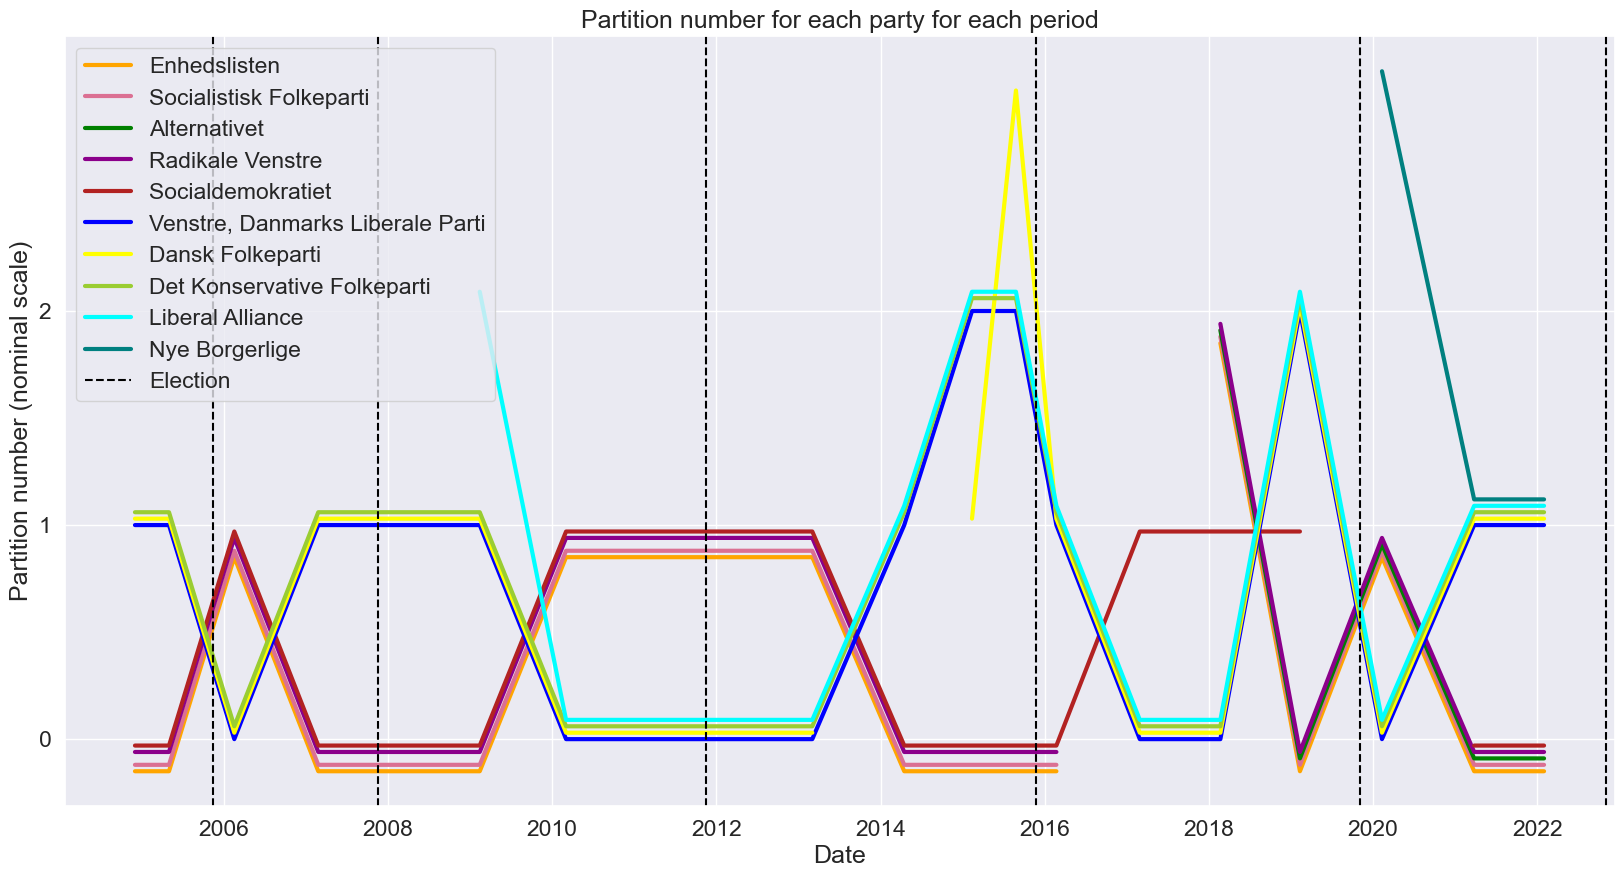

In [371]:
#We plot all the parties
import seaborn as sns

sns.set_style("darkgrid")

#set text size and font style to arial
sns.set(font = 'Arial')
sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(20,10))
middle_date = [periods_dict[period][1] for period in periods]
offset = 0
constant = 0.15
for party in parties:
    #We get the partition number for the party for each period
    partition_number = [party_period[(party, period)] for period in periods]
    #add offset if the entries in partition_number are not None
    partition_number = [x + offset - constant if x is not None else x for x in partition_number]
    #We plot the partition number for the party for each period
    ax.plot(middle_date, partition_number, label = party, color = color_map[party], linewidth = 3)
    offset = offset + 0.03
#We plot the elections
for election in elections:
    #if last election
    if election == elections[-1]:
        ax.axvline(election, color = 'black', linestyle = '--', label = 'Election')
    else:
        ax.axvline(election, color = 'black', linestyle = '--')

ax.legend()


#make y ticks only be 0, 1, 2
ax.set_yticks([0, 1, 2])
ax.set_xlabel('Date')
ax.set_ylabel('Partition number (nominal scale)')
ax.set_title('Partition number for each party for each period')
plt.show()


### We now move onto clusterting distance from Socialdemokratiet

In [48]:
#get laws per period
df.groupby('periode_id').count()['afstemnings_id']

periode_id
20      80
21     162
22     222
23     202
24       1
25     186
26     207
27     217
28     205
30     189
31     228
32     200
35     173
138      7
139    183
144    215
146    240
148    219
150      1
151    145
153    252
155    162
Name: afstemnings_id, dtype: int64

There are a number of laws during corona where the aktørid was not stored.
We remove these laws

In [49]:
corona_laws = [7901, 7907, 7916, 7917, 7918, 7920, 7921, 7927, 7928, 7929, 7930, 7931, 7944, 7945, 7946, 7947, 7949, 7974, 7975, 7976, 7977, 7978, 7979, 7980, 7981, 7982, 7983, 7984, 7985, 7988, 7989, 7990, 7991, 7998, 7999, 8000, 8001, 8002, 8003, 8004, 8012, 8013, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8024, 8025, 8026, 8040, 8043, 8044, 8045, 8046, 8047, 8048, 8049, 8050, 8051, 8052]

In [50]:
#We remove all laws from periode_id 153 where the aktørid is not stored
print(f'There are {len(df[df["periode_id"] == 153])} laws in periode_id 153')
print(f'There are {len(corona_laws)} laws in periode_id 153 where the aktørid is not stored due to corona circumstances')



There are 252 laws in periode_id 153
There are 66 laws in periode_id 153 where the aktørid is not stored due to corona circumstances


In [51]:
#WE check whether the laws in corona_laws are in the df
np.isin(corona_laws, df['afstemnings_id'].unique())
#They are not in the df

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [52]:
#check whether all nodes in G_uni.nodes() have a party
for node in G_uni.nodes():
    try: 
        G_uni.nodes[node]['party'][153]
    except KeyError:
        print(node)

19809


In [54]:
###### THIS VERSION KINDA WORKS EXCEPT PERHAPS NOT WRT RANDOM ######
#set random seed
np.random.seed(42)
#unique periods
periods = df['periode_id'].unique()
#remove periods 24, 7 and  150
periods = periods[~np.isin(periods, [24, 138, 150])]


distance_all_periods = defaultdict()

right_wing_parites = ['Venstre, Danmarks Liberale Parti', 'Det Konservative Folkeparti', 'Dansk Folkeparti', 'Liberal Alliance', 'Nye Borgerlige']


for periode_id in periods:
    print(f'Working on periode_id {periode_id}')

    #get the df for the periode_id
    df_period = df[df['periode_id'] == periode_id]

    G = create_bipartite_graph(df_period)

    #set attributes for politicians
    G = set_politician_attributes(G)

    #clean graph
    #remove the isolated nodes
    #remove_isolate_nodes(G)

    law_nodes, politician_nodes = nx.bipartite.sets(G)

    color_map = create_color_map() #defined in graph_functions.py

    G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

    if periode_id == 153:
        #remove nodes 19809
        G_uni.remove_nodes_from([19809])
        #also remove the edges between 19809 and the other nodes
        G_uni.remove_edges_from([(19809, node) for node in G_uni.nodes()])
        #also remove the edges between the other nodes and 19809
        G_uni.remove_edges_from([(node, 19809) for node in G_uni.nodes()])

    #We take all social democrats as a grouip
    soc_politicians = [node for node in G_uni.nodes() if G_uni.nodes[node]['party'][periode_id] == 'Socialdemokratiet']
    
    #other_parties = [party for party in parties if party != 'Socialdemokratiet']
    distances = defaultdict()
    #We calculate the average weight of the edges between the social democrats and the other parties
    for party in parties:
        #get the nodes for the party
        nodes_party = [node for node in G_uni.nodes if G_uni.nodes[node]['party'][periode_id] == party]
        if len(nodes_party) < 3: #remove parties with less than 3 politicians
            continue
        #calculate the average weight of the edges between the social democrats and all parties including themselves
        try: 
            average_weight = np.mean([G_uni.edges[(soc_politician, node)]['weight'] for soc_politician in soc_politicians for node in nodes_party if soc_politician != node])
        except KeyError:
            average_weight = []
            number_of_bad_edges = 0
            for soc_politician in soc_politicians:
                for node in nodes_party:
                    if soc_politician != node:
                        try:
                            average_weight.append(G_uni.edges[(soc_politician, node)]['weight'])
                        except KeyError:
                            print(f'KeyError for {soc_politician} and {node} in periode_id {periode_id}')
                            number_of_bad_edges += 1
                            continue
            average_weight = np.mean(average_weight)
            print(f'Number of bad edges: {number_of_bad_edges}')
        distances[party] = average_weight

    #We normalize by divding by the number of laws in the period
    distances = {party: distance/len(df_period) for party, distance in distances.items()}

    #max_distance = max(distances.values())
    #min_distance = min(distances.values()) 
    #distances = {party: (distance - min_distance)/(max_distance - min_distance) for party, distance in distances.items()}
    #We flip the distances
    distances = {party: 1 - distance for party, distance in distances.items()}

    #if the party is right wing we make the distance negative
    distances = {party: -distance if party in right_wing_parites else distance for party, distance in distances.items()}

    distance_all_periods[periode_id] = distances





Working on periode_id 32
Working on periode_id 31
Working on periode_id 30
Working on periode_id 28
Working on periode_id 35
Working on periode_id 27
Working on periode_id 139
Working on periode_id 144
Working on periode_id 146
Working on periode_id 26
Working on periode_id 25
Working on periode_id 23
Working on periode_id 22
Working on periode_id 21
Working on periode_id 20
Working on periode_id 148
Working on periode_id 151
Working on periode_id 153
KeyError for 67 and 44 in periode_id 153
KeyError for 197 and 44 in periode_id 153
KeyError for 18717 and 44 in periode_id 153
KeyError for 18882 and 44 in periode_id 153
Number of bad edges: 4
KeyError for 67 and 219 in periode_id 153
KeyError for 16503 and 18709 in periode_id 153
KeyError for 16503 and 15788 in periode_id 153
KeyError for 152 and 18709 in periode_id 153
KeyError for 152 and 15788 in periode_id 153
KeyError for 197 and 219 in periode_id 153
KeyError for 18717 and 219 in periode_id 153
KeyError for 18882 and 219 in period

It is unclear what is causing these bad edges, but we just choose to ignore them since it is only 12 for a single period

In [56]:
#find the party with the smallest absolute distance per period
closest_party = defaultdict()
for periode_id, distances in distance_all_periods.items():
    closest_party[periode_id] = min(distances, key = lambda x: abs(distances[x]))
closest_party

defaultdict(None,
            {32: 'Socialdemokratiet',
             31: 'Socialdemokratiet',
             30: 'Radikale Venstre',
             28: 'Socialdemokratiet',
             35: 'Socialdemokratiet',
             27: 'Socialdemokratiet',
             139: 'Socialdemokratiet',
             144: 'Socialdemokratiet',
             146: 'Socialdemokratiet',
             26: 'Venstre, Danmarks Liberale Parti',
             25: 'Venstre, Danmarks Liberale Parti',
             23: 'Socialdemokratiet',
             22: 'Socialdemokratiet',
             21: 'Det Konservative Folkeparti',
             20: 'Socialdemokratiet',
             148: 'Socialdemokratiet',
             151: 'Socialdemokratiet',
             153: 'Socialdemokratiet',
             155: 'Socialdemokratiet'})

In [57]:
# #unique periods
# periods = df['periode_id'].unique()
# #remove periods 24, 7 and  150
# periods = periods[~np.isin(periods, [24, 138, 150, 153])]


# distance_all_periods = defaultdict()

# right_wing_parites = ['Venstre, Danmarks Liberale Parti', 'Det Konservative Folkeparti', 'Dansk Folkeparti', 'Liberal Alliance', 'Nye Borgerlige']


# for periode_id in periods:
#     print(f'Working on periode_id {periode_id}')

#     #get the df for the periode_id
#     df_period = df[df['periode_id'] == periode_id]

#     G = create_bipartite_graph(df_period)

#     #set attributes for politicians
#     G = set_politician_attributes(G)

#     #clean graph
#     #remove the isolated nodes
#     remove_isolate_nodes(G)

#     law_nodes, politician_nodes = nx.bipartite.sets(G)

#     color_map = create_color_map() #defined in graph_functions.py

#     G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

#     #We take all social democrats as a grouip
#     soc_politicians = [node for node in G_uni.nodes() if G_uni.nodes[node]['party'][periode_id] == 'Socialdemokratiet']

#     other_parties = [party for party in parties if party != 'Socialdemokratiet']
#     distances = defaultdict()
#     #We calculate the average weight of the edges between the social democrats and the other parties
#     for party in other_parties:
#         #get the nodes for the party
#         nodes_party = [node for node in G_uni.nodes if G_uni.nodes[node]['party'][periode_id] == party]
#         if len(nodes_party) == 0:
#             continue
#         #calculate the average weight of the edges between the social democrats and the other party
#         average_weight = np.mean([G_uni.edges[(soc_politician, node)]['weight'] for soc_politician in soc_politicians for node in nodes_party])
#         distances[party] = average_weight

#     #We normalize the distances
#     #As min distance, we calculate the average distance between the social democrats and themselves
#     minimum_distance = []
#     for soc_politician1 in soc_politicians:
#         for soc_politician2 in soc_politicians:
#             if soc_politician1 != soc_politician2:
#                 minimum_distance.append(G_uni.edges[(soc_politician1, soc_politician2)]['weight'])
#     min_distance = np.mean(minimum_distance)

#     #As max distance, we calculate the the highest possible distance to the social democrats - i.e. an imaginary party voting the opposite
#     #We define an imaginary party with the same number of nodes as soc_politicians
#     imaginary_party = [f'inv{i}' for i in soc_politicians]
#     #We add edges to the laws which are 1 - the weight of the edge between the social democrats and the law
#     for law in law_nodes:
#         for count, imaginary_politician in enumerate(imaginary_party):
#             ### PROBLEM RIGHT HERE ### #maybe check order of soc count and law
#             try:
#                 socweight =  G.edges[(law, soc_politicians[count])]['weight']
#             except KeyError: #This happens when a social democrat has voted blank on a law.
#                 #choose the same weight as soc_before. This is not perfect, but close approximation of what we want
#                 socweight =  G.edges[(law, soc_politicians[count - 1])]['weight']
#             G.add_edge(law, imaginary_politician, weight = 1 - socweight)

#     law_nodes, politician_nodes = nx.bipartite.sets(G)

#     color_map = create_color_map() #defined in graph_functions.py

#     G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)


#     #We calculate the average distance between the social democrats and the imaginary party
#     max_distance = np.mean([G_uni.edges[(soc_politician, imaginary_politician)]['weight'] for soc_politician in soc_politicians for imaginary_politician in imaginary_party])

#     ### This is probably not necessary, but just to be safe ###
#     #We remove the edges between the laws and the imaginary party
#     for law in law_nodes:
#         for imaginary_politician in imaginary_party:
#             G_uni.remove_edge(law, imaginary_politician)
#     #We remove the imaginary party nodes
#     G_uni.remove_nodes_from(imaginary_party)

#     #max_distance = max(distances.values())
#     #min_distance = min(distances.values())
#     distances = {party: (distance - min_distance)/(max_distance - min_distance) for party, distance in distances.items()}
#     #We flip the distances
#     distances = {party: 1 - distance for party, distance in distances.items()}

#     #if the party is right wing we make the distance negative
#     distances = {party: -distance if party in right_wing_parites else distance for party, distance in distances.items()}

#     distance_all_periods[periode_id] = distances





In [58]:
#sort periods by the middle date
periods = sorted(periods, key=lambda x: periods_dict[x][1])

In [59]:
#We go through the distance_all_periods and assign each party a None value if the party is not in the distance_all_periods
for party in parties:
    for periode_id in periods:
        if party not in distance_all_periods[periode_id]:
            distance_all_periods[periode_id][party] = None


In [60]:
distance_all_periods

defaultdict(None,
            {32: {'Enhedslisten': 0.2463333333333334,
              'Socialistisk Folkeparti': 0.013125000000000053,
              'Radikale Venstre': 0.0012750000000000261,
              'Socialdemokratiet': 0.0012499999999999734,
              'Venstre, Danmarks Liberale Parti': -0.19072606382978718,
              'Dansk Folkeparti': -0.29571590909090917,
              'Det Konservative Folkeparti': -0.18120833333333342,
              'Liberal Alliance': -0.335375,
              'Alternativet': None,
              'Nye Borgerlige': None},
             31: {'Enhedslisten': 0.20720361509835195,
              'Socialistisk Folkeparti': 0.006415185691501568,
              'Radikale Venstre': 0.006738437001594821,
              'Socialdemokratiet': 0.005966952264381931,
              'Venstre, Danmarks Liberale Parti': -0.2261762360446571,
              'Dansk Folkeparti': -0.28757068290561116,
              'Det Konservative Folkeparti': -0.225549669628617,
            

In [129]:
#get the first and last datetime entry in periods_dict
first_date = periods_dict[periods[0]][1]
last_date = periods_dict[periods[-1]][1]

#only keep year, month and day
periods_dict[periods[-1]][2]


datetime.datetime(2022, 5, 19, 0, 0)

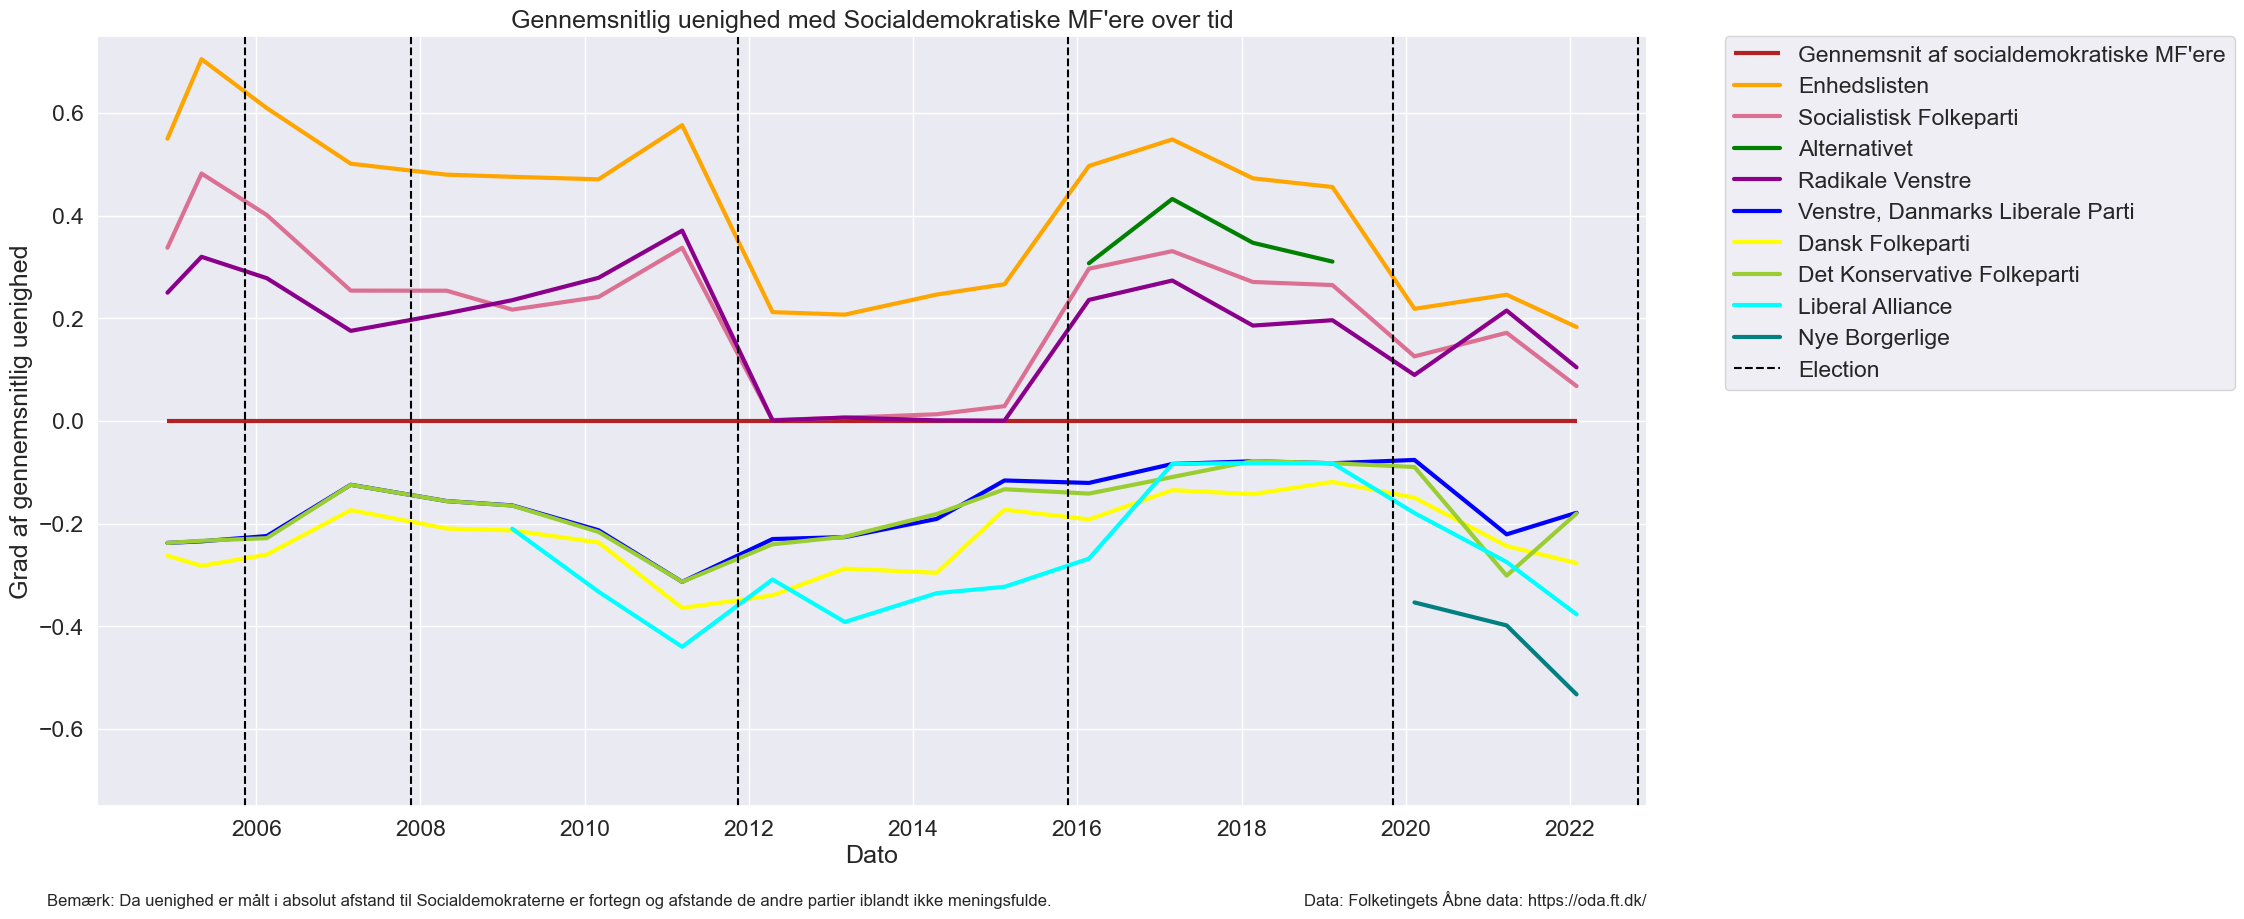

In [143]:
#We plot all the parties
import seaborn as sns

#We plot the distance between the social democrats and the other parties
sns.set_style("darkgrid")

#set text size

#set font to arial
sns.set(font="Arial")
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(20,10))
middle_date = [periods_dict[period][1] for period in periods]
offset = 0.02
other_parties = [party for party in parties if party != 'Socialdemokratiet']
ax.hlines(0, xmin = first_date, xmax=last_date, color = 'firebrick', label = "Gennemsnit af socialdemokratiske MF'ere", linewidth = 3)
for party in other_parties:
    #We get the partition number for the party for each period if the distance is not None
    distance = [distance_all_periods[period][party] for period in periods if distance_all_periods[period][party] is not None]
    middle_date = [periods_dict[period][1] for period in periods if distance_all_periods[period][party] is not None]
    #start_date = [periods_dict[period][0] for period in periods if distance_all_periods[period][party] is not None] #an argument could be made for using start date
    ax.plot(middle_date, distance, label = party, color = color_map[party], linewidth = 3)


#We plot the elections
for election in elections:
    #if last election
    if election == elections[-1]:
        ax.axvline(election, color = 'black', linestyle = '--', label = 'Election')
    else:
        ax.axvline(election, color = 'black', linestyle = '--')
#ax.axvline(datetime.datetime(2008,8,28), color = 'black', linestyle = '-', label = 'Ny Alliance becomes Liberal Alliance')
#plot legend outside of plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Dato')
ax.set_ylabel("Grad af gennemsnitlig uenighed")
ax.set_title("Gennemsnitlig uenighed med Socialdemokratiske MF'ere over tid")
ax.set_ylim(-0.75,0.75)
#set figure footnote 
fig.text(0.9, 0.01, 'Data: Folketingets Åbne data: https://oda.ft.dk/', ha='right', fontsize = 12)
fig.text(0.1, 0.01, 'Bemærk: Da uenighed er målt i absolut afstand til Socialdemokraterne er fortegn og afstande de andre partier iblandt ikke meningsfulde.', ha='left', fontsize = 12)
plt.show()





In [62]:
#We figure out how many members of alternativet there were in 2020
periods_dict[15

SyntaxError: unexpected EOF while parsing (1779002416.py, line 2)

In [159]:
#We find out how many members of alternativet there were in period 151
df_period = df[df['periode_id'] == 155]
G = create_bipartite_graph(df_period)
G = set_politician_attributes(G)
law_nodes, politician_nodes = nx.bipartite.sets(G)
G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

#We find the edges between Mette Frederiksen and Jakob Ellemann-Jensen
#WE find the aktørid for Mette Frederiksen
Mette_Frederiksen = [node for node in G_uni.nodes if G_uni.nodes[node]['name'] == 'Mette Frederiksen'][0]
Jakob_Ellemann_Jensen = [node for node in G_uni.nodes if G_uni.nodes[node]['name'] == 'Jakob Ellemann-Jensen'][0]
print(f'The aktørid for Mette Frederiksen is {Mette_Frederiksen}')
print(f'The aktør id for Jakob Ellemann-Jensen is {Jakob_Ellemann_Jensen}')

Dan_Jørgensen = [node for node in G_uni.nodes if G_uni.nodes[node]['name'] == 'Dan Jørgensen'][0]
print(f'The aktørid for Dan Jørgensen is {Dan_Jørgensen}')


The aktørid for Mette Frederiksen is 138
The aktør id for Jakob Ellemann-Jensen is 207
The aktørid for Dan Jørgensen is 167


In [160]:
#We find how many times they voted together
print(f'The number of times they voted together is {G_uni[Mette_Frederiksen][Jakob_Ellemann_Jensen]["weight"]}')
print(f'The number of times they voted together is {G_uni[Mette_Frederiksen][Dan_Jørgensen]["weight"]}')

The number of times they voted together is 133
The number of times they voted together is 161


In [148]:
len(df_period)

162

In [169]:
G.edges['p8799',Mette_Frederiksen]['weight']

1

In [156]:
#we find the first and last date in the period
first_date = df_period['dato_sagstrin'].min()
last_date = df_period['dato_sagstrin'].max()
print(f'The first date in the period is {first_date}')
print(f'The last date in the period is {last_date}')


The first date in the period is 2021-10-14T00:00:00
The last date in the period is 2022-05-19T00:00:00


In [ ]:
G_uni.nodes[12]['politician']

KeyError: 'politician'

In [126]:
len(df)

3696